# MLP for Adult Income Classification (PyTorch)

Binary classification to predict whether annual income > $50K using Multi-Layer Perceptron with PyTorch.


In [1]:
import os
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "ucimlrepo"], check=False)

import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


GPU: Tesla T4


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## Data Loading


In [3]:
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

print(adult.metadata)
print(adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [4]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nMissing values:\n{X.isnull().sum()}")
print(f"\nTarget distribution:\n{y.value_counts()}")


Features shape: (48842, 14)
Target shape: (48842, 1)

Missing values:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

Target distribution:
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64


## Data Preprocessing


In [5]:
X_clean = X.copy()
y_clean = y.copy()

# Handle missing values
X_clean = X_clean.fillna(X_clean.mode().iloc[0])

# Encode categorical features
X_encoded = pd.get_dummies(X_clean, drop_first=True)

# Convert target to binary (0 for <=50K, 1 for >50K)
y_binary = (y_clean.iloc[:, 0].str.strip() == '>50K').astype(int).values

print(f"Encoded features shape: {X_encoded.shape}")
print(f"Target distribution:\n{pd.Series(y_binary).value_counts()}")


Encoded features shape: (48842, 100)
Target distribution:
0    41001
1     7841
Name: count, dtype: int64


In [6]:
# Train/Validation/Test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.15, random_state=seed, stratify=y_binary
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=15/85, random_state=seed, stratify=y_temp
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val_scaled)
y_val_t = torch.FloatTensor(y_val)
X_test_t = torch.FloatTensor(X_test_scaled)
y_test_t = torch.FloatTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 34188, Val: 7327, Test: 7327


In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super(MLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims

        # For hidden layers
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            # Dropout-turns off neurons randomly during training so we dont rely on one neuron too much.
            layers.append(nn.Dropout(dropout_rate))

        # For output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(1)

input_dim = X_train_scaled.shape[1]
model = MLP(input_dim, hidden_dims=[128, 64], dropout_rate=0.3).to(device)
print(model)


MLP(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Training


In [ ]:
class_counts = np.bincount(y_train)
class_weights = len(y_train) / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 7
patience_counter = 0

checkpoint_path = '/content/best_mlp_adultincome.pt' if IN_COLAB else 'best_mlp_adultincome.pt'

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # clears all gradients
        optimizer.zero_grad()
        # Output is a logit, not a probability
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        # backprop
        loss.backward()
        # Updates params
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # validation loop

    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(y_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), checkpoint_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0:
        val_f1 = f1_score(np.array(val_targets), np.array(val_preds))
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1:.4f}')

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Epoch 5/50 - Train Loss: 0.5668, Val Loss: 0.5826, Val F1: 0.5496
Epoch 10/50 - Train Loss: 0.5491, Val Loss: 0.5793, Val F1: 0.5515
Early stopping at epoch 13


<All keys matched successfully>

In [9]:
from sklearn.metrics import precision_recall_curve

model.eval()
y_val_proba = []
y_val_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs).cpu().numpy()
        y_val_proba.extend(probs)
        y_val_true.extend(y_batch.numpy())

y_val_proba = np.array(y_val_proba)
y_val_true = np.array(y_val_true)

thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = []
for thresh in thresholds:
    preds = (y_val_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_val_true, preds))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold:.3f} (F1: {f1_scores[optimal_idx]:.4f})')

Optimal threshold: 0.500 (F1: 0.5511)


## Evaluation


In [10]:
model.eval()
y_pred_proba = []
y_pred_binary = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs >= optimal_threshold).astype(int)

        y_pred_proba.extend(probs)
        y_pred_binary.extend(preds)
        y_true.extend(y_batch.numpy())

y_pred_proba = np.array(y_pred_proba)
y_pred_binary = np.array(y_pred_binary)
y_true = np.array(y_true)

# Metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred_proba)

print("Test Set Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['<=50K', '>50K']))


Test Set Metrics:
Accuracy:  0.8031
Precision: 0.4348
Recall:    0.7577
F1-Score:  0.5526
ROC-AUC:   0.8667

Confusion Matrix:
[[4993 1158]
 [ 285  891]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.95      0.81      0.87      6151
        >50K       0.43      0.76      0.55      1176

    accuracy                           0.80      7327
   macro avg       0.69      0.78      0.71      7327
weighted avg       0.86      0.80      0.82      7327



## Visualizations


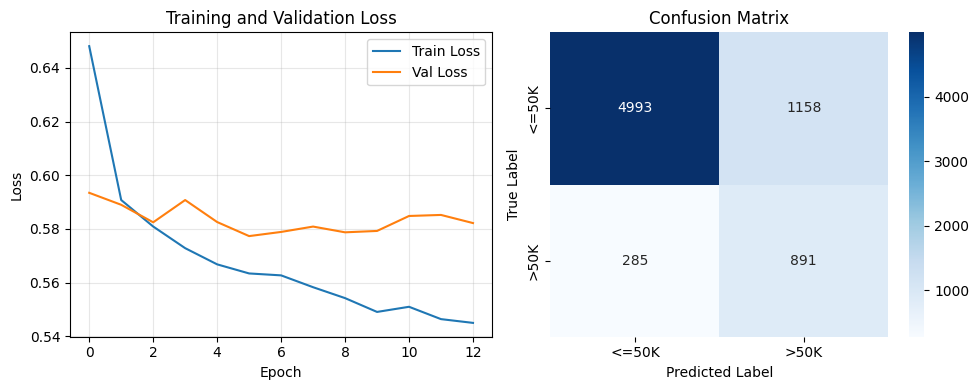

In [ ]:
# Training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()
